### 텐서플로, 케라스API 를 사용해 인공신경망 구축하기

앞선 연습에서는 Pytorch를 사용해서 인공신경망을 구축했다. 이번에는 텐서플로의 Keras API를 사용하여, 좀더 고수준에서 keras.Sequential을 이용하여 인공신경망을 쌓고 훈련하는 것까지 해보자.

케라스는 모듈식 프로그래밍 인터페이스를 제공하기 때문에 몇 줄의 코드로 복잡한 모델을 빠르게 만들 수 있다.


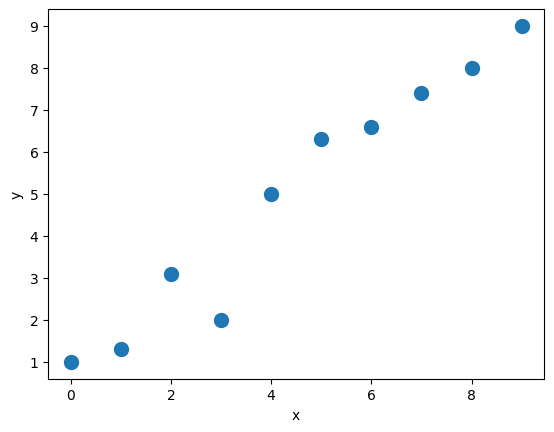

In [3]:
# keras로 선형회귀 모델 구현

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# 데이터 생성
X_train = np.arange(10).reshape((10, 1)) # create column vector
Y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])
plt.plot(X_train, Y_train, 'o', markersize=10)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [28]:
# 특성 표준화 : ( X_train - 평균 ) / 표준편차  ( 평균 0, 표준편차 1 )

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)

# 텐서플로 데이터셋 생성
# 표준화된 특성과, 타겟 레이블을 튜플형식으로 모아서 데이터 형성
# cast : 텐서의 요소 데이터 타입을 변환한다.
dataset_train_origin = tf.data.Dataset.from_tensor_slices((tf.cast(X_train_norm, tf.float32), tf.cast(Y_train, tf.float32)))
[print(x.numpy() , y.numpy()) for x, y in dataset_train_origin]

# 클래스를 통해서 인공신경망 구축
# tf.keras.Model 에는 여러 Neural Network의 기본적인 기능이 구현되어 있다.
# 여러 모델 아키텍쳐와 레이어를 쉽게 구축할 수 있다.
# fit(), evaluate(), predict() 등의 메소드를 제공한다.
class LinearRegression(tf.keras.Model): 

    def __init__(self): # initialize model parameters
        super(LinearRegression, self).__init__()
    
        # Tensorflow 변수 생성
        # 학습과정에서 업데이트 되는 변수를 생성한다.
        self.W = tf.Variable(0.01, name='weight')
        self.b = tf.Variable(0.015, name='bias')

    # Neural Network의 Forward Pass를 정의 
    # 인스턴스를 호출할 때 입력값을 자동으로 전달한다.
    def call(self, x):
        return self.W * x + self.b

# 모델 생성
model = LinearRegression()

# late variable creation
# 임의의 길이를 가지는 열벡터를 입력으로 설정한다.
model.build(input_shape=(3,1))

# 모델 요약
model.summary()


[-1.5666989] 1.0
[-1.2185436] 1.3
[-0.87038827] 3.1
[-0.52223295] 2.0
[-0.17407766] 5.0
[0.17407766] 6.3
[0.52223295] 6.6
[0.87038827] 7.4
[1.2185436] 8.0
[1.5666989] 9.0


Model: "linear_regression_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
# 손실함수 및 최적화 알고리즘 설정

# MSE 손실함수
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

# SGD 최적화 알고리즘 : 저수준으로 SGD를 직접 구현
# compile(), fit() 메소드를 사용하면, 자동으로 최적화 알고리즘을 설정할 수 있다. (SGD, Adam, RMSprop 등) : Keras의 장점
def train(model, inputs, outputs, lr): #model: 신경망 모델 , inputs: 입력 데이터, outputs: true output(레이블), lr: 학습률
    
    # tf.GradientTape() : 자동 미분을 위한 API
    # with 구문 내의 연산을 기록한다. 이후, 이 연산( 여기서는 current_loss) 에 대한 미분의 결과들이 전부 기록된다.
    # 만약 current_loss가 with 구문 밖에서 사용되면, tape.gradient에 의한 미분값이 기록되지 않는다.
    with tf.GradientTape() as tape:

        # 미분 대상을 지정하고, 이 대상의 미분을 기록한다.
        current_loss = loss_fn(model(inputs), outputs)
    
    # tape.gradient( target, source ) : target에 대한 source의 미분값을 계산한다.
    # source를 리스트 형태로 넣으면, 각각에 대한 미분값을 리스트(요소=텐서)로 반환한다.
    dW,db = tape.gradient(current_loss, [model.W, model.b])

    # 모델 파라미터 업데이트
    # weight, bias를 입력값으로 빼면서 업데이트한다.
    model.W.assign_sub(lr * dW) # W = W - lr * dW
    model.b.assign_sub(lr * db) # b = b - lr * db


In [8]:
# 훈련 데이터를 이용하여, 정의한 모델 학습
tf.random.set_seed(1)

# 하이퍼파라미터 설정
lr = 0.001 # 학습률
epochs = 200 # 에포크
log_steps = 100 # 결과 로그 출력 주기
batch_size = 1 # 배치 사이즈
steps_per_epoch = len(Y_train) // batch_size # 1 에포크(전체 데이터셋을 한번 학습) 당 반복 횟수

# 데이터셋 셔플 및 배치 설정
dataset_train = dataset_train_origin.shuffle(buffer_size=len(Y_train))  # (데이터, 레이블) 쌍을 레이블 길이만큼 섞는다.
dataset_train = dataset_train.repeat(count=None) # 데이터셋을 무한정 반복한다.
dataset_train = dataset_train.batch(batch_size) # 배치 사이즈만큼 데이터셋을 나눈다.

# 추후 데이터 시각화용 리스트 생성
Ws, bs = [], []
losses = []

# 학습 루프

# take() 메소드 : 데이터셋에서 지정된 개수의 요소를 반환한다.
# epochs * steps_per_epoch = 총 에포크수 * 1 에포크 당 반복 횟수 = 총 반복 횟수
# 1에포크 = 전체 데이터셋을 한번 학습하는 것.
for i, (x, y) in enumerate(dataset_train.take(epochs * steps_per_epoch)):

    # 반복당 손실값 저장
    current_loss = loss_fn(model(x), y)

    # 파라미터 시각화용 리스트 추가
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    losses.append(current_loss)

    # 모델 학습 : 파라미터 업데이트
    train(model, x, y, lr)

    # 로그 출력
    if i % log_steps == 0:
        print(f'Epoche = {i // steps_per_epoch : 3d}, Step = {i:4d}, Loss = {current_loss.numpy():6.4f}')



Epoche =   0, Step =    0, Loss = 43.5600
Epoche =  10, Step =  100, Loss = 0.7530
Epoche =  20, Step =  200, Loss = 20.1759
Epoche =  30, Step =  300, Loss = 23.3976
Epoche =  40, Step =  400, Loss = 6.3481
Epoche =  50, Step =  500, Loss = 4.6356
Epoche =  60, Step =  600, Loss = 0.2411
Epoche =  70, Step =  700, Loss = 0.2036
Epoche =  80, Step =  800, Loss = 3.8177
Epoche =  90, Step =  900, Loss = 0.9416
Epoche =  100, Step = 1000, Loss = 0.7035
Epoche =  110, Step = 1100, Loss = 0.0348
Epoche =  120, Step = 1200, Loss = 0.5404
Epoche =  130, Step = 1300, Loss = 0.1170
Epoche =  140, Step = 1400, Loss = 0.1195
Epoche =  150, Step = 1500, Loss = 0.0944
Epoche =  160, Step = 1600, Loss = 0.4670
Epoche =  170, Step = 1700, Loss = 2.0695
Epoche =  180, Step = 1800, Loss = 0.0020
Epoche =  190, Step = 1900, Loss = 0.3612


2025-01-31 20:25:43.889934: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


W = 2.6576621532440186, b = 4.879856586456299


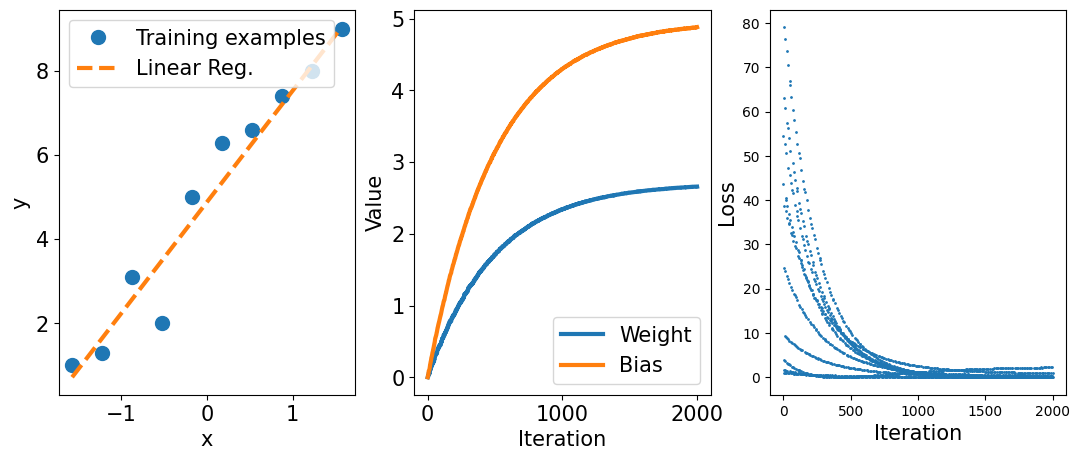

In [14]:
# 최종 학습 결과 출력
print(f'W = {model.W.numpy()}, b = {model.b.numpy()}')

# 시각화 및 결과 출력

X_test = np.linspace(0, 9, num=100).reshape(-1, 1) # 테스트 데이터 생성 : -1~1 사이의 100개의 데이터 생성
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train) # 테스트 데이터 표준화

Y_pred = model(tf.cast(X_test_norm, dtype=tf.float32)) # 예측값 생성 : 모델에 테스트 데이터를 넣어 예측 회귀선 생성

fig = plt.figure(figsize=(13, 5))

# 1행 2열의 그래프 생성, 1번 그래프 : 훈련 데이터와 예측 회귀선
ax = fig.add_subplot(1, 3, 1)
plt.plot(X_train_norm, Y_train, 'o', markersize=10) # 훈련 데이터
plt.plot(X_test_norm, Y_pred, '--', lw=3) # 예측 회귀선
plt.legend(['Training examples', 'Linear Reg.'], fontsize=15)
plt.xlabel('x', size=15)
plt.ylabel('y', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# 1행 2열의 그래프 생성, 2번 그래프 : 파라미터 변화
ax = fig.add_subplot(1, 3, 2)
plt.plot(Ws, lw=3) # weight , lw : 선 굵기
plt.plot(bs, lw=3) # bias
plt.legend(['Weight', 'Bias'], fontsize=15)
plt.xlabel('Iteration', size=15)
plt.ylabel('Value', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

# 1행 3열 그래프 생성, 3번 그래프 : 손실값 변화
ax = fig.add_subplot(1, 3, 3)
plt.plot(losses, 'o' ,markersize=1)
plt.xlabel('Iteration', size=15)
plt.ylabel('Loss', size=15)


plt.show()

